# Introduction

Derivatives are used to solve a large variety of modern-day problems. There are three general methods used to calculate derivatives:
1. Symbolic differentiation 
2. Numerical differentiation
3. Automatic differentiation 

Symbolic differentiation can be very useful, but there are some functions that do not have a symbolic derivative. Additionally, symbolic differentiation can be very costly, as it may recalculate the same expressions many times, or the expression for the derivative may grow exponentially. Sometimes we can avoid these issues by numerically differentiating our function. Often this means using finite differences. The method of finite differences calculates derivative at point $x$ by using the following definition:

$$f'(x) = \lim_{h\to 0} f(x) \frac{f(x+h)-f(x)}{h}$$ 

Finite differences can also be very effective in certain situations. However, as with symbolic differentiation, finite differences has its problems. The biggest issue is that to obtain the most accurate estimate of $f'(x)$, we would like to make $h$ as small as possible; in fact, we would like $h$ to be infinitely small. However, we cannot *actually* make $h$ zero, and thus we must compromise and choose some small-but-not-zero value for $h$, which brings us to our second problem: we cannot precisely represent all numbers. Our machines only have a certain level of precision. When we compute our derivatives numerically we introduce error by approximating values to their closest machine equivalent. To avoid these issues, we turn to our third approach: automatic differentiation. Automatic differentiation computes derivatives by repeatedly applying the chain rule to recursively compute derivatives of elementary arithmetic operations and functions.

For our package extension, we chose to implement root finding and a basic function fitting neural network class. Our neural network class is mostly fixed, but allows the dimensions of the input and number of hidden nodes to be changed. Root finding is used in many contexts for optimization, and function fitting is useful for making predictions based on a given set of data.

# How to use the package

## Installation

Please follow these two steps in sequence to install:

1. Clone https://github.com/autodiff-cs207/AutoDiff.git
2. After cloning, please run:

   `python setup.py install`
   
Alternatively, to install from PyPI:
1. `pip install AutoDiff_207_15`

## Demos

Note that the demos can only be run locally after installing the AutoDiff package.

Import the package:

In [1]:
from AutoDiff import DiffObj, Variable, VectorFunction
from AutoDiff import MathOps as mo
from AutoDiff.nn import NeuralNet
from AutoDiff.root_finder import ThreadWithReturnValue, vectorNewton, pretty_print_results
import numpy as np
import matplotlib.pyplot as plt
import math

### Basic Demo

Some elementary math operators:

In [2]:
val_dict = {'x' : 10, 'y' : 20, 'z' : 1}
x = Variable('x')
y = Variable('y')

In [3]:
f0 = x + y
print('Value:    ', f0.get_val(val_dict))
print('Gradient: ', f0.get_der(val_dict))

Value:     30
Gradient:  {'y': 1, 'x': 1}


In [4]:
f1 = x/y
print('Value:    ', f1.get_val(val_dict))
print('Gradient: ', f1.get_der(val_dict))

Value:     0.5
Gradient:  {'y': -0.025, 'x': 0.05}


In [5]:
f2 = x + y + 1
print('Value:    ', f2.get_val(val_dict))
print('Gradient: ', f2.get_der(val_dict))

Value:     31
Gradient:  {'y': 1, 'x': 1}


Other math operators and exponentiation:

In [6]:
val_dict1 = {'x' : 2, 'y' : 0}
val_dict2 = {'x': 3, 'y': math.pi/3, 'z' : 10}
val_dict3 = {'x' : math.pi/2, 'y' : math.pi/4, 'z' : 2}

In [7]:
f3 = -mo.log(x)
print('Value:    ', f3.get_val(val_dict1))
print('Gradient: ', f3.get_der(val_dict1))

Value:     -0.6931471805599453
Gradient:  {'x': -0.5}


In [8]:
f4 = x**4
print('Value:    ', f4.get_val(val_dict2))
print('Gradient: ', f4.get_der(val_dict2))

Value:     81
Gradient:  {'x': 108.0}


In [9]:
f5 = mo.sin(x + y)
print('Value:    ', f5.get_val(val_dict3))
print('Gradient: ', f5.get_der(val_dict3))

Value:     0.7071067811865476
Gradient:  {'y': -0.7071067811865475, 'x': -0.7071067811865475}


### Root Finder Demo
Note that because start points are randomized, the root finder is not deterministic; try running the second of the two root finding demos multiple times to see varied output.
Finds a root of input function f(x) = 5x + 3 with AutoDiff's root_finder module.

RootFinder found a total of 1 roots for the function

Found root: {'x': -1.0}
Function value at root: [0.0]
Number of iterations needed to find the root: 2
List of error values:[469, 0.0]



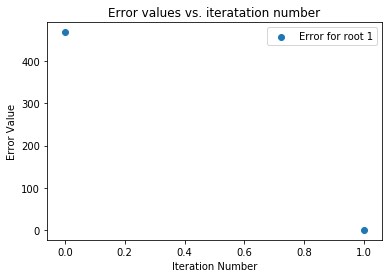

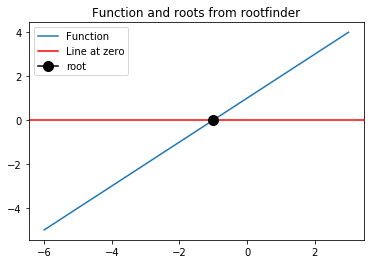

Evaluation of our function at root number 0: 0.0


In [10]:
import random
from scipy.interpolate import interp1d

random.seed(13)

# Demo a very basic test 
x = Variable('x')
y = Variable('y')

test_f0 =  x+1

results_t0= vectorNewton(test_f0, num_starting_vals=10, verbose=True)
results_t0
pretty_print_results(results_t0)

roots = [result[0]['x'] for result in results_t0]
val_at_root = [result[1] for result in results_t0]

plt.title("Function and roots from rootfinder")
x_plt = np.arange(min(roots)-5, max(roots)+5,1)
y_plt= x_plt+1
x_new = np.linspace(min(x_plt), max(x_plt),500)
f = interp1d(x_plt, y_plt)
y_smooth=f(x_new)
plt.plot (x_new,y_smooth) 
plt.axhline(y=0,color='r')
plt.plot(roots, val_at_root, marker='o', markersize=10, color="black")
plt.legend(["Function","Line at zero","root"])
#plt.scatter(x_plt,y_plt)
plt.show()

for i, root in enumerate(roots):
    r = test_f0.get_val({'x':root})
    print("Evaluation of our function at root number {}: {}".format(i,r))

RootFinder found a total of 8 roots for the function

Found root: {'x': -2.6179938779914944}
Function value at root: [5.551115123125783e-17]
Number of iterations needed to find the root: 4
List of error values:[0.35887999194013276, 0.016980024232598923, 9.188335746213028e-05, 2.8134944374258453e-09]

Found root: {'x': -6.806784082763037}
Function value at root: [1.2859158182720876e-11]
Number of iterations needed to find the root: 3
List of error values:[0.7794154981989259, 0.004291970696631786, 6.211160336111465e-06]

Found root: {'x': 9.948376736367667}
Function value at root: [1.0047518372857667e-14]
Number of iterations needed to find the root: 3
List of error values:[0.044021110889369885, 0.0007283398926479223, 1.764833407746913e-07]

Found root: {'x': -8.901179185171083}
Function value at root: [1.7763568394002505e-15]
Number of iterations needed to find the root: 6
List of error values:[1.4589242746631386, 1.1581787472654437, 0.23112634926503084, 0.03715963723278376, 0.000417494

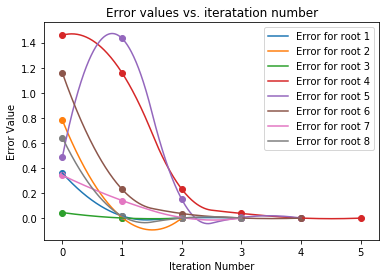

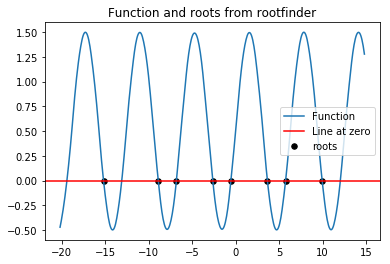

Evaluation of our function at root number 0: 5.551115123125783e-17
Evaluation of our function at root number 1: 1.2859158182720876e-11
Evaluation of our function at root number 2: 1.0047518372857667e-14
Evaluation of our function at root number 3: 1.7763568394002505e-15
Evaluation of our function at root number 4: 2.434619172930752e-11
Evaluation of our function at root number 5: 1.1102230246251565e-15
Evaluation of our function at root number 6: 1.5959511490137857e-11
Evaluation of our function at root number 7: -1.1102230246251565e-16


In [11]:
# Demo a function with many roots 
x = Variable('x')
test_f2 = mo.sin(x)+0.5
results_t2= vectorNewton(test_f2, num_starting_vals=20, starting_val_range = (-10,10), verbose=True)
pretty_print_results(results_t2)

roots = [result[0]['x'] for result in results_t2]
val_at_root = [result[1] for result in results_t2]

plt.title("Function and roots from rootfinder")
x_plt = np.arange(min(roots)-5, max(roots)+5,1)
y_plt= np.sin(x_plt)+0.5
x_new = np.linspace(min(x_plt), max(x_plt),500)
f = interp1d(x_plt, y_plt, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new,y_smooth) 
plt.axhline(y=0,color='r')
plt.scatter(roots, val_at_root, marker='o', s=30, color="black")
plt.legend(["Function","Line at zero","roots"])
plt.show()

for i, root in enumerate(roots):
    r = test_f2.get_val({'x':root})
    print("Evaluation of our function at root number {}: {}".format(i,r))

RootFinder found a total of 2 roots for the function

Found root: {'y': 1.9809373421798498e-17, 'x': -1.9809373421798498e-17}
Function value at root: [1.9809373421798498e-17, 0.0]
Number of iterations needed to find the root: 12
List of error values:[12180, 2835.437501377594, 708.7968808545256, 177.13674225025616, 44.221773646937216, 10.993294758188886, 2.6872134067374263, 0.6146230196268218, 0.10922721454323465, 0.008302951386940304, 6.672301009699169e-05, 4.450772200752827e-09]

Found root: {'y': -1.0, 'x': 1.0}
Function value at root: [0.0, 0.0]
Number of iterations needed to find the root: 15
List of error values:[635662, 158204.9375000247, 39551.17187510495, 9887.730469171296, 2471.8701188730256, 617.905036038742, 154.41378428651586, 38.541047097218595, 9.573164573434067, 2.3323817712954913, 0.5266460586443844, 0.08928007423670614, 0.005873415697668527, 3.3705154425245354e-05, 1.1358842755271326e-09]



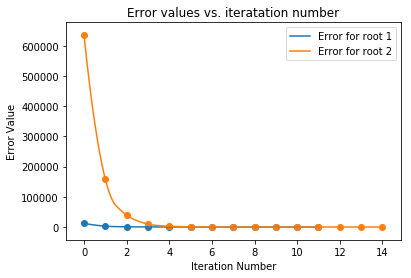

Evaluation of our function at root number 0: [1.9809373421798498e-17, 0.0]
Evaluation of our function at root number 1: [0.0, 0.0]


In [13]:
# Demo a vector valued function
x = Variable('x')
y = Variable('y')

test_f3 = VectorFunction([x**2+y, y+x])
results_t3= vectorNewton(test_f3, num_starting_vals=10, verbose=True)
pretty_print_results(results_t3)

roots = [result[0] for result in results_t3]
val_at_root = [result[1] for result in results_t3]

for i, root in enumerate(roots):
    r = test_f3.get_val(root)
    print("Evaluation of our function at root number {}: {}".format(i,r))

RootFinder found a total of 3 roots for the function

Found root: {'x3': 0.1449316569875842, 'x1': 1.0989425786269242, 'x2': 0.3676166798271156}
Function value at root: [1.648730041381441e-10, -1.2653877945467684e-11, -6.0827121117768e-11]
Number of iterations needed to find the root: 34
List of error values:[43494661, 2728279788.224541, 735630032.3675457, 177772274.92872214, 61636218.371008724, 12862187.103012213, 2553170.7024898403, 28425729.40577887, 8403823.31531859, 2483068.668997096, 726980.7406233466, 212011.65842703314, 61807.58500216453, 18033.93539348761, 5269.325492361575, 1542.7665105325755, 453.01453565206884, 133.5878016829805, 39.99093848474334, 20.66659732221497, 10.126242365528258, 135.65814026096587, 1233.9199003832548, 380.66001207017007, 120.32827050461646, 55.84875464970435, 3.2219971606748556, 0.3760181480770073, 0.09473938099527252, 0.02382287894291868, 0.005271784958037096, 0.0009863639551856984, 9.229885195571885e-05, 1.2419102369265467e-06]

Found root: {'x3':

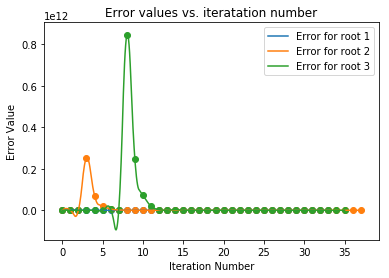

Evaluation of our function at root number 0: [1.648730041381441e-10, -1.2653877945467684e-11, -6.0827121117768e-11]
Evaluation of our function at root number 1: [8.289171571362886e-10, -3.9479086666460717e-11, -3.0565372455271245e-10]
Evaluation of our function at root number 2: [4.1522341120980855e-14, -1.2612133559741778e-13, 8.056888489704761e-13]


In [14]:
# Demo a second vector valued function
x1 = Variable('x1')
x2 = Variable('x2')
x3 = Variable('x3')

f1 = x1**2 - 2*x1+x2**2-x3+1
f2 = x1*x2**2-x1-3*x2+x2*x3+2
f3 = x1*x3**2-3*x3+x2*x3**2+x1*x2

test_f4 = VectorFunction([f1,f2,f3])
results_t4= vectorNewton(test_f4, num_starting_vals=5, verbose=True)
pretty_print_results(results_t4)

roots = [result[0] for result in results_t4]
val_at_root = [result[1] for result in results_t4]

for i, root in enumerate(roots):
    r = test_f4.get_val(root)
    print("Evaluation of our function at root number {}: {}".format(i,r))

### Neural Network Demo
Trains a neural network to find a fit for a set of inputs and corresponding outputs

In [15]:
input_dim = 1
hidden_dim = 12
out_dim = 1
lr = 0.03
nn = NeuralNet(input_dim, hidden_dim, out_dim, lr)

X_data = np.random.randn(3000, input_dim)
y_data = np.sin(np.multiply(X_data, X_data))
num_train = 2700
X_train, y_train = X_data[0:num_train,:], y_data[0:num_train]
X_test, y_test = X_data[num_train:,:], y_data[num_train:]

In [ ]:
num_epochs = 60
tol = 1e-4
prev_loss = 1e6
for epoch in range(num_epochs):
    running_loss = 0
    for i in range(X_train.shape[0]):
        loss, _ = nn.forward(X_train[i,:], y_train[i])
        running_loss += loss[0]
        nn.backward()
    print('Loss after epoch {} is: {:.4f}'.format(epoch + 1, running_loss))
    if abs(running_loss - prev_loss) < tol:
        print('Training converged, stopping early.')
        break
    prev_loss = running_loss

In [ ]:
# Test on the test set and plot against train set
y_pred = [0.0]*len(y_test)
for i in range(len(y_test)):
    _, pred = nn.forward(X_test[i,:], y_test[i])
    y_pred[i] = list(pred)[0]
    
fig = plt.gcf()
fig.set_size_inches(9, 6)
_ = plt.scatter(X_test[:,0], y_test, marker='o', s=10, label=r'Ground Truth ($f(x) = sin(x^2)$)')
_ = plt.scatter(X_test[:,0], y_pred, marker='v', s=10, label='Prediction (on Test Set)')
_ = plt.xlabel('X', fontsize=14)
_ = plt.ylabel('y', fontsize=14)
_ = plt.legend(loc='best', fontsize=14)
_ = plt.title('Ground Truth vs Predictions (after {} epochs)'.format(num_epochs), fontsize=14)
fig.savefig('neural_net.png')

# Background
Automatic differentiation (AD) allows us to calculate the derivative to machine precision while avoiding symbolic differentiation's shortcomings. Our package implements on version of AD, the forward mode, by using an extension of the real numbers called the "dual numbers." The forward mode of AD finds the derivative of all intermediate variables with respect to our independent variable and combines them into a final derivative using the chain rule.

AD can also be used in "reverse mode," which we will not discuss in detail her, but this method shares many of the same characteristics as forward mode. However, the reverse mode computes derivatives of the dependent variable with respect to the intermediate variables. 

#### Dual Numbers
To carry out the forward mode AD we utilize dual numbers. Dual numbers are defined as numbers of the form $x + x'\epsilon$, where $\epsilon^2=0$ and $x \in \mathbb{R}^n$. We use operator overloading to redefine elementary operations to suit our problem. To see why this is useful, let's examine how dual numbers behave under different mathematical operations:

Addition: $(x+x'\epsilon) + (y + y'\epsilon) = x+y + (x'+y')\epsilon$

Subtraction: $(x+x'\epsilon) - (y + y'\epsilon) = x-y + (x'-y')\epsilon$

So far, this is as we might expect.

Multiplication: $(x+x'\epsilon) \times (y + y'\epsilon) = xy + y(x')\epsilon+ x(y')\epsilon$

Our definition of $\epsilon$ allows the multiplication of dual numbers to behave like the product rule.

Division: $\frac{(x+x'\epsilon)}{(y + y'\epsilon)} = \frac{(x+x'\epsilon)(y - y'\epsilon)}{(y + y'\epsilon)(y - y'\epsilon)} = \frac{xy+xy'\epsilon-yx'\epsilon}{y^2} = \frac{x}{y}+\epsilon \frac{xy'-yx'}{y^2}$

Division also follows rules for derivatives.

Finally, observe how functions of dual numbers behave:

$f(x+x'\epsilon) = f(x)+\epsilon f'(x)x'$

Which implies the following:

$g(f(x+x'\epsilon)) = g(f(x)+\epsilon f'(x)x') = g(f(x))+\epsilon g'(f(x))f'(x)x'$

The above example illustrates how dual numbers can be used to simultaneously calculate the value of a function at a point, $g(f(x))$, and the derivative, $g'(f(x))f'(x)x'$.

#### Tracing the computational graph
By keeping track of the intermediate values of the derivative we can calculate the derivative of composition of many elementary functions. We can picture this decomposition as a graph or table. For example, consider the following function$^{1}$: $$f\left(x, y, z\right) = \dfrac{1}{xyz} + \sin\left(\dfrac{1}{x} + \dfrac{1}{y} + \dfrac{1}{z}\right).$$

If we want to evaluate $f$ at $\left(1, 2, 3\right)$, we can construct the following table which keeps track for the elementary function, current value, and the elementary function derivative (evaluated with respect to all our variables).

| Trace | Elementary Function | Current Value | Elementary Function Derivative | $\nabla_{x}$ Value  | $\nabla_{y}$ Value  | $\nabla_{z}$ Value  |
| :---: | :-----------------: | :-----------: | :----------------------------: | :-----------------: | :-----------------: | :-----------------: |
| $x_{1}$ | $x_{1}$ | $1$ | $\dot{x}_1$ | $1$ | $0$ | $0$ | 
| $x_{2}$ | $x_{2}$ | $2$ | $\dot{x}_2$ | $0$ | $1$ | $0$ | 
| $x_{3}$ | $x_{3}$ | $3$ | $\dot{x}_3$ | $0$ | $0$ | $1$ | 
| $x_{4}$ | $1/x_{1}$ | $1$ | $-\dot{x}_{1}/x_{1}^{2}$ | $-1$ | $0$ | $0$ | 
| $x_{5}$ | $1/x_{2}$ | $\frac{1}{2}$ | $-\dot{x}_{2}/x_{2}^{2}$ | $0$ | $-\frac{1}{4}$ | $0$ | 
| $x_{6}$ | $1/x_{3}$ | $\frac{1}{3}$ | $-\dot{x}_{3}/x_{3}^{2}$ | $0$ | $0$ | $-\frac{1}{9}$ | 
| $x_{7}$ | $x_4 x_5 x_6$ | $\frac{1}{6}$ | $x_4(x_5\dot{x}_6 + x_6\dot{x}_5) + x_5x_6\dot{x}_4$ | $-\frac{1}{6}$ | $-\frac{1}{12}$ | $-\frac{1}{18}$ | 
| $x_{8}$ | $x_4 + x_5 + x_6$ | $\frac{11}{6}$ | $\dot{x}_4 + \dot{x}_5 + \dot{x}_6$ | $-1$ | $-\frac{1}{4}$ | $-\frac{1}{9}$ | 
| $x_{9}$ | $sin(x_8)$ | $sin(\frac{11}{6})$ | $cos(x_8)\dot{x}_8$ | $-cos(\frac{11}{6})$ | $-\frac{1}{4}cos(\frac{11}{6})$ | $-\frac{1}{9}cos(\frac{11}{6})$ | 
| $x_{10}$ | $x_7 + x_9$ | $sin(\frac{11}{6})+\frac{1}{6}$ | $\dot{x}_7 + \dot{x}_9$ | $-cos(\frac{11}{6})-\frac{1}{6}$ | $-\frac{1}{4}cos(\frac{11}{6})-\frac{1}{12}$ | $-\frac{1}{9}cos(\frac{11}{6})-\frac{1}{18}$ | 

As this example shows, we can use AD for both scalar and vector functions. AD can also be used for vector valued functions. The follow sections will make the implementation of these varients clear.

$^1$Example from Harvard CS207 Homework 4

# Software Organization

## Directory Structure

```
AutoDiff/
    AutoDiff/
        __init__.py
        ad.py
        nn.py
        root_finder.py
        root_finder_multiple.py
        tests/
            test_root_finder.py
            test_AutoDiff.py
            test_root_finder_multiple.py
    README.md
    setup.py
    LICENSE
    requirements.txt
```

## Basic Modules
Our ad.py file contains our main classes: DiffObj, Variable, VectorFunction, and MathOps, all imported in our init file. This main module supports basic automatic differentiation. Our package contains two other modules: nn to support basic function fitting with neural networks, and root_finder to find roots of input functions.

## Testing
Comprehensive tests can be found in the /tests directory. Testing is automated with both TravisCI and Coveralls. In addition, we have also written DocTest code for each class function and our package passes all doctest by running doctest.testmod().

Note that for root_finder, when dealing with functions that have many y values very close to the actual roots, you may have to scale tolerance to weed out incorrect root values (as with the function f(x) = x^3, for which using the default tolerance gave a list of roots containing many values very close to x = 0).

# Implementation Details

## Core Data Structures

There are two core data structures in our implementation:

1. **Lists**: The name_list (a list of strings) representing variable names, that is stored in every Diffobj instance to indicate the variables influencing that instance. Eg. for the DiffObj w, where w represents sin(x)+y, the name_list of Variable x is ['x'], the name_list of Variable y is ['y'] and the name_list of w is ['x','y'].

2. **Dictionaries**: The dictionary value_dict, an argument of DiffObj.get_der, containing names and values that indicate the point in space at which we need to compute derivative and evaluate an expression, for example in w.get_val(value_dict). We also use Dictionarie for storing partial derivatives with respect to variables.

## Core Classes

### 1. Class DiffObj()
Any function for which a user wants to evaluate its value and gradient, will be represented by an instance of this class DiffObj, or by instances of classes which inherit from DiffObj (e.g. class Variable, etc.) A mathematical equivalent of a DiffObj object will be:
 * a variable such as $x$, which we have implemented via a Sub-class 'Variable'
 * a mathematical expression such as $x^2 + sin(y)$.

DiffObj enforces that each class which inherits from it, must implement two functions:

    CLASS FUNCTIONS
    ==================
    The functions get_val and get_der are exposed to the user, that is, a user of our package can
    call these functions.

    (1) get_val:        This is used to evaluate the function represented by a DiffObj instance at
                        a particular point.

    (2) get_der:        This is used to evalate the gradient of the function repreesnted by a DiffObj
                        instance, at a particular point.
   
    CLASS ATTRIBUTES
    ================
    The attributes are not meant to be used by an end-user of our package, and they are meant for internal
    computation.

    name_list:          A list of strings, where each item in the list represents the variables inside
                        the function represented by this DiffObj. E.g. for f(x,y) = x + y, the name_list
                        for a DiffObj representing f will be ['x', 'y'] (assuming the x.name_list = ['x']
                        and y.name_list = ['y'].
    operator:           A single string representing the "operator". By default, DiffObj assumes that it
                        represents two DiffObj's connected by an binary operator such as 'add'. However,
                        we use the same definition for unary operators such as negation or cosine.
    operand_list:       A list of two DiffObjs, which together with self.operator, comprise this instance
                        of DiffObj.

    CLASS FUNCTIONS
    ================
    get_val(self, value_dict)
        INPUT
        ======
        value_dict:     A dictionary, whose keys are strings representing variables which feature
                        in the formula represented by this DiffObj. The values at those keys are
                        the values at which the formula representing this DiffObj will be evaluated.

                        E.g. For a DiffObj which represents the function f(x,y) = x + y, the value_dict
                        argument may look like value_dict = {'x': 10, 'y': 5}
        OUTPUT
        ======

        DOCTEST
        ======
        >>> z=x+y
        >>> z.get_val({'x':1,'y':1})
        2


        result:         A floating point number, which equals the evaluation of the function
                        represented by this DiffObj, at the variable values given by val_dict.

    get_der(self, value_dict, with_respect_to=None)
        INPUT
        ======
        value_dict:         A dictionary, whose keys are strings representing variables which feature
                            in the formula represented by this DiffObj. The values at those keys are
                            the values at which the gradient of formula representing this DiffObj will
                            be evaluated.

                            E.g. For a DiffObj which represents the function f(x,y) = x + y, the value_dict
                            argument may look like value_dict = {'x': 10, 'y': 5}
        with_respect_to:    A list of strings representing variables, with respect to which we want the
                            gradient of this DifObj. By default, if this list is not provided, then the
                            gradient with respect to all variables featuring in the DiffObj is returned.

        OUTPUT
        ======
        result:             A dictionary, whose keys are strings representing variables which feature
                            in the formula represented by this DiffObj. The value associated withe each
                            key is a floating point number which is the partial derivative of this DiffObj
                            with respect to that variable.

        DOCTEST
        ======
        >>> z=x+y
        >>> z.get_der({'x':0,'y':0})
        {'y': 1, 'x': 1}
        
    Other class functions: These include the overloaded operators listed in the functionality section above. 
                            We have provided detailed documentation for these overloaded functions inside our code. 

### 2. Class Variable(DiffObj)
This subclass inherits from DiffObj, and is basically used for representing a variable such as x or y.

    All variables inside a function whose derivative and value a user wants to calculate,
    will be instances of the Variable class, which inherits from DiffObj and implements
    get_val and get_der

    CLASS ATTRIBUTES
    ================
    var_name:           A string, which is unique to this Variable instance.
                        E.g. x = Variable('x')

    CLASS FUNCTIONS
    ===============
    This implements get_val and get_der, a description of which is provided in the
    Super-class DiffObj.

### 3. Class MathOps()
    This class inherits from the DiffObj class. It implements non-elementary unary functions
    including: sin, cos, tan, log, exp.

    INSTANTIATION
    ===============
    If a is of type DiffObj, then the invoking the constructor as follows will return an
    object b of type MathOps:

    b = MathOps.sin(a)

    CLASS ATTRIBUTES
    ================
    The attributes are not meant to be used by an end-user of our package, and they are meant for internal
    computation.

    name_list:          A list of strings, where each item in the list represents the variables inside
                        the function represented by this DiffObj. E.g. for f(x,y) = x + y, the name_list
                        for a DiffObj representing f will be ['x', 'y'] (assuming the x.name_list = ['x']
                        and y.name_list = ['y'].
    operator:           A string, such as 'sin' or 'log', which represents one of the unary math operators
                        implemented by this class.
    operand_list:       A list of length 1 containing the DiffObj which the user has passed as an argument
                        to one of the classmethods of MathOps.
    CLASS FUNCTIONS
    ================
    Note: This class implements classmethods named 'sin', 'cos', 'tan', 'log' and 'exp', and these
    classmethods basically return an instance of type DiffObj, which supports get_val and get_der
    for functions like sin, log, cos, tan, exp.

### 4. Class NeuralNet()
    This class implements a simple Neural Network using our Auto-Differentiation package. Basic
    idea is that each node in a Neural Net represents a differntiatble function.

    INSTANTIATION
    ===============
    Invoking the constructor as follows will return an object net of type NeuralNet:

    net = NeuralNet(a, input_dim=2, hidden_dim=10, out_dim=1)
    - input_dim is Integer, represents dimension of the input.
    - hidden_dim is Integer, represents number of nodes in the hidden layer.
    - output_dim is Integer, represents dimension of the output. Currently we only support 
       1 for this value.

    CLASS ATTRIBUTES
    ================
    The attributes are not meant to be used by an end-user of our package, and they are meant for internal
    computation.

    name_list:          A list of strings, where each item in the list represents the variables inside
                        the function represented by this DiffObj. E.g. for f(x,y) = x + y, the name_list
                        for a DiffObj representing f will be ['x', 'y'] (assuming the x.name_list = ['x']
                        and y.name_list = ['y'].
    operator:           A string, such as 'sin' or 'log', which represents one of the unary math operators
                        implemented by this class.
    operand_list:       A list of length 1 containing the DiffObj which the user has passed as an argument
                        to one of the classmethods of MathOps.
    CLASS FUNCTIONS
    ================
    The key functions are as follows:
    def forward(self, X, y):
       This implements a forward pass through the network.
       
       INPUT
       =====
       X: A NumPy array of dimensions (input_dim x 1), this represents a single training sample. We do not
          support training in batches currently.
       y: A real number, this represents the Response Variable. Currently we do not support Categorical
          responses.
       
       OUTPUT
       ======
       loss:        A real number representing the L2 loss of the network.
       output_val:  The value of the output node for this forward pass.
    
    def backward(self):
       This implements a backward pass through the network.
       
       INPUT
       =====
       None. It uses values cached during the forward pass.
       
       OUTPUT
       ====== 
       No output - this function computes gradients and invokes UpdateParams
       to update weights of the network.
    
    def AffineLayer(self, in_obj, wt_var, activation=False):
       This implements an affine layer with optional Sigmoid activation.
       
       INPUT
       =====
       in_obj: A list of DiffObj instances which represents outputs of the previous
               layer in the network.
       wt_var: A list of dictionaries. The length of list equals hidden_dim. Each
               dictionary represents weights used by a hidden node to interact with
               outputs of the previous layer.
       activation: If True then Sigmoid activation is used for final output of this layer.

# Implementation Details - Root Finding

## root_finder

This package allows the user to find the root of a specified function. It includes one function, VectorNewton, which finds an unspecified number of roots for scalar or multivariate vector functions. Because the number of roots may be unknown, root_finder uses a multithreading approach to quickly find roots, if they exist. The function works as follows:

    1) A user specifies a function to root_finder
    2) If not user provided, root_finder generates a list of starting values from the user specified or 
       default range
    3) The root_finder searches in parallel for roots, starting at each starting value
    4) Roots are found by using Newton's method: the tangent line is used as an approximate function at the point
       and found using our AutoDiff package. The intercept of the tangent is found, and the next candidate point
       is generated by calculating the function at the intersection of the tangent with the zero line/plane.
    5) The error (distance from 0) is calculated, and if within tolerance, the root is returned. Otherwise, the 
       process continues until the max number of iterations is reached (100). 


    PACKAGE USE
    ===========
    If f is of type DiffObj, then the user calls the function VectorNewton as:

    result = vectorNewton(f)
    
    FUNCTION SIGNATURE
    ==================
    vectorNewton(input_function,tolerance=1e-5, num_starting_vals = 20, 
	starting_val_range = (-1000,1000), starting_val_dict_list=None, verbose=True)

    FUNCTION ARGUMENTS
    ==================

    input_function:     This is the DiffObj object that the user would like to find the root of. It can either 
                        an DiffObj or the child class, VectorFunction.
                        
    tolerance:          Optional float argument with default 1e-5. This is the threshold for considering a root. 
                        That is the norm(potential root)<tolerance to be considered a root.
                        
    num_starting_vals:  Optional argument with default value 20. Functions can have many roots, and a user may not
                        know how many roots to expect before starting. This is the number of different starting 
                        values that the root_finder will check.
    starting_val
            _range: 
                        Optional argument, with default value (-1000,1000). This is the range of values over which 
                        the root_finder will select starting values. If the function is multivariate, all variables 
                        will be selected from this range. If the user does not supply starting values, or does not 
                        supply as many starting values as specified in num_starting_vals, starting values will 
                        be generated randomly in this range.
    starting_
        val_dict_list:  Optional argument, default value None. If the user would like to specify a list of starting
                        values, they may do so using this parameter. For example, the user could input the list
                        [{'x':4},{'x':10}] if they wanted to using the starting values 4 and 10. If they did not 
                        specify a number of starting values, then 18 more starting values would be generated from 
                        the starting_val_range. 
                        
    verbose:            Optional argument, default True. If verbose is False, only the root values are returned 
                        after the function completes. If verbose is True, then a list of lists is returned. 
                        The outer list is a list of roots, and for each root there is a list with the first entry 
                        corresponding to the root value, the second to the function evaluated at the root value, 
                        the third corresponding to the number of iterations taken to find the root, and the 
                        fourth is a list of errors generated for each iteration of the root_finder on that root. 
                        For example, if the root_finder returned 
                        [[{'x':1.0},0.0,3,[10,5,0]],[{'x':2.0},0.1,3,[15,5,0.01]], we found two roots with values 
                        1.0 and 2.0 respectively. They evaluated to 0.0 and 0.1 respectively, and took 3 steps each. 
                        The final entries are the error lists for each root. 
                    
    FUNCTION OUTPUT
    ================
    output:             Depending on the user input of verbose, the function either returns a list of dictionarys

## Dependencies

Our package relies on Math and NumPy.